# Assignment 1 Q2

**Codes and notes for CS5242 Assignment 1 Q2**

Import python libraries

In [1]:
from __future__ import division
import numpy as np
import random
import re
import csv
import os
import matplotlib.pyplot as plt

## Activation and cost/loss functions

ReLU and (stable) softmax; Cross-entropy + softmax

In [2]:
# activation functions
class ReLU():
    def activator(self, input_x):
        return np.maximum(0, input_x)

    def derivative(self, dinput):
        return (dinput > 0)*1

class softmax():
    def activator(self, input_x):

        exps = np.exp(input_x - np.max(input_x))
        return exps/np.sum(exps)

# cross entropy + softmax
class cross_entropy_softmax():
    @staticmethod
    def cost(o, y):
        '''
        o = network output
        y = labels
        '''
        y = y.reshape(1,-1)
        o = o.reshape(1,-1)
        log_likelihood = -np.sum(np.nan_to_num(y*np.log(o)))
        return log_likelihood

    @staticmethod
    def derivative(o, y):
        # using softmax in final layer
        return o-y

## Network formulation

Inputs: 
* layer_activation_tuples = [(no. of neurons in input layer,),  (no. of neurons in hidden_layer1, activator function class), ..., (no. of neurons in output_layer, activator function class)]
* learning_rate, cost_function
* training_data = list of tuples "(x, y)" representing the training inputs and the desired outputs (labels).
* epochs, batch_step_size

In [3]:
class network(object):
    
    def __init__(self, layer_activator_tuples, learning_rate, preset_weights=None, preset_biases=None):
        self.learning_rate = learning_rate

        self.layer_size_list = [_[0] for _ in layer_activator_tuples]
        self.layer_actfunc_list = [_[1] for _ in layer_activator_tuples[1:]]
        self.num_layers = len(self.layer_size_list)

        self.calculate_gradients = 0 # binary to compute gradients daL/dw, daL/db

        # initialise weights and biases (random values based on standard gaussian distribution if none is given)
        sizes_in_hidden_and_output_layers = self.layer_size_list[1:]
        sizes_in_input_and_hidden_layers = self.layer_size_list[:-1]

        if preset_weights == None:
            # List of weights between all layers; Dim(weights) = j (to, curr) x k (from) - each entry is the weight 
            # association with the connection of the k-th neuron of the previous layer to the j-th neuron in the current
            # layer
            # in each layer:
            # row = number of neurons in current layer; column = number of neurons in previous layer
            # [(j1, k0), (j2, k1),..., (jl, kl-1) ,..., (jL, kL-1)]
            # where kl = jl-1
            self.weights = [np.random.randn(n_to, n_from).astype(np.float32) for n_from, n_to in
                            zip(sizes_in_input_and_hidden_layers,
                                sizes_in_hidden_and_output_layers)]
        else:
            self.weights = preset_weights
            self.calculate_gradients = 1

        if preset_biases == None:
            # List of biases for all hidden + output layers; Dim(biases) = j x 1 - each neuron in hidden and output 
            # layer will have their individaul bias
            # [(j1, 1), (j2, x 1), ..., (jL x 1)]
            self.biases = [np.random.randn(n, 1).astype(np.float32) for n in sizes_in_hidden_and_output_layers]
        else:
            self.biases = preset_biases
            self.calculate_gradients = 1
    
    # feedforward function
    def feedforward(self, input_x, weight, bias, activator):
        weighted_input = np.dot(weight, input_x) + bias
        return weighted_input, activator(weighted_input)

    # stochastic gradient descent
    def SGD(self, training_data, epochs, batch_step_size):
        '''
        training_data = list of tuples "(x, y)" representing the training inputs and the desired outputs (labels).
        dimensions of x/y -> jl x 1 / jL x 1
        '''
        training_cost = []
        training_accuracy = []

        n = len(training_data)  # total number of training data

        for j in xrange(epochs):
            # shuffle training data in each iteration
            random.shuffle(training_data)
            # sample the mini-batches
            mini_batches = [training_data[k:k+batch_step_size] for k in xrange(0, n, batch_step_size)]
            for mini_batch in mini_batches:
                # apply gradient descent for each mini-batch
                
                if self.calculate_gradients == 1:
                    # Question 2_2 - calculate gradients 
                    return self.gradient_descent(mini_batch)
                else: 
                    # Question 2_1
                    self.gradient_descent(mini_batch)
                    
            # calculate total cost
            cost, accuracy = self.calculate_total_cost_and_accuracy(training_data)

            training_cost.append(cost)
            training_accuracy.append(accuracy)
        
        return training_cost, training_accuracy

    def gradient_descent(self, mini_batch):
        '''
        Update the network's weights and biases by applying gradient descent using backpropagation
        '''

        # empty matrices to store
        nabla_b = [np.zeros(b.shape, dtype=np.float32) for b in self.biases]
        nabla_w = [np.zeros(w.shape, dtype=np.float32) for w in self.weights]

        for x, y in mini_batch:
            # with each mini-batch (training data set), update the weights and biases based on a single iteration of
            # gradient descent

            # apply backpropagation algorithm to get
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)

            nabla_b = [nb + dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw + dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        
        # Question 2_2 - calculate gradients 
        if self.calculate_gradients == 1:
            return (nabla_b, nabla_w)

        self.weights = [w - (self.learning_rate/len(mini_batch))*nw for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b - (self.learning_rate/len(mini_batch))*nb for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        '''
        Return a tuple ``(nabla_b, nabla_w)`` representing the gradient for the cost function C_x. ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar to ``self.biases`` and ``self.weights``.
        '''

        nabla_b = [np.zeros(b.shape, dtype=np.float32) for b in self.biases]
        nabla_w = [np.zeros(w.shape, dtype=np.float32) for w in self.weights]

        # feedforward
        a = x # initialise a with input x
        activations = [x] # list to store activations by layer (a0 = x), l = 0..L
        weighted_inputs = [] # list to store weighted inputs by layer (z = activator(a)), l = 1..L

        for l, (b, w) in enumerate(zip(self.biases, self.weights)):
            # get activator function of layer l
            actfunc = self.layer_actfunc_list[l]
            # feedforward to get weighted input and activation
            z, a = self.feedforward(a, w, b, actfunc.activator)
            weighted_inputs.append(z)
            activations.append(a)

        # compute delta in output layer L = (d_C/d_aL)*(d_aL/d_zL)
        # d_C/d_aL where aL = output of network (final activation of output layer) -
        # i.e. rate of change wrt output activations
        actfunc = self.layer_actfunc_list[-1] # get activator function of output layer L
        delta = cross_entropy_softmax.derivative(activations[-1], y)
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())

        # starting from the layer before the output layer (last hidden layer) to input layer
        for l in xrange(2, self.num_layers):
            z = weighted_inputs[-l]
            actfunc = self.layer_actfunc_list[-l]  # l index of layer_size_list = l-1 index of layer_actfunc_list
            sp = actfunc.derivative(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())

        return nabla_b, nabla_w
    
    def calculate_total_cost_and_accuracy(self, data):
        cost = 0.0
        positives = 0

        for x, y in data:
            a = x
            for l, (b, w) in enumerate(zip(self.biases, self.weights)):
                # get activator function of layer
                actfunc = self.layer_actfunc_list[l]
                # feedforward to get weighted input and activation
                z, a = self.feedforward(a, w, b, actfunc.activator)

            cost_increment = cross_entropy_softmax.cost(a, y)/len(data)
            cost += cost_increment

            if a.argmax() == y.argmax():
                positives += 1

        return cost, positives/len(data)

## Run networks

Run all neural networks (in a loop) for all data (train and test, Q2_1), and preset gradients (stpiulated Q2_c).

Outputs for Q2_1 = Plots of training cost and accuracy (density v. epochs)  
Outputs for Q2_2c = csv files for gradients in the format required.

Training network 100-40-4...
Training network 14-28-4...


/home/alvin/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log
/home/alvin/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in multiply


Training network 28-6-4...
train


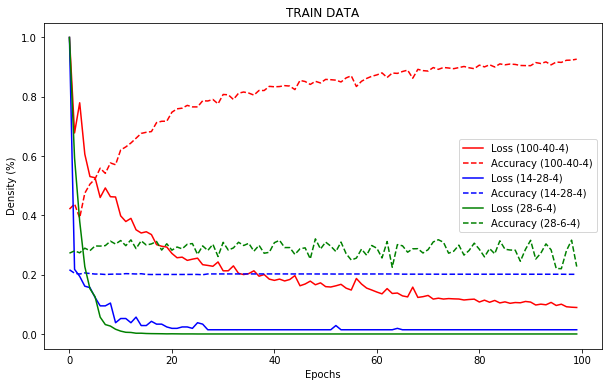

test


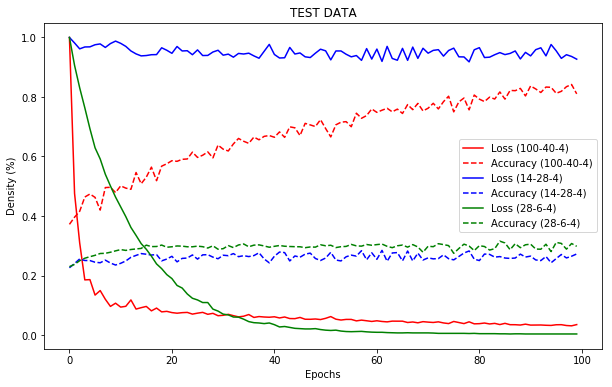

In [4]:
layer_keys = ['100-40-4', '14-28-4', '28-6-4']
# stochastic gradient descent parameters
epochs = 100
batch_step_size = 10
# fix random seeds to get same result regardless of run start
random.seed(666)
np.random.seed(666)

# Question 2_1
data_keys = ['train', 'test']
q2_1 = {}

# Question 2_2 
data_point = [(np.array([-1, 1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1], dtype=np.float32).reshape(-1,1),
               np.eye(4, dtype=np.float32)[np.array([3])].reshape(4, 1))]

for layer_key in layer_keys: 
    print ('Training network {}...'.format(layer_key))
    
    # set up layer_activator_tuples and learning_rate
    if layer_key == '100-40-4':
        layer_activator_tuples = [(14,), (100, ReLU()), (40, ReLU()), (4, softmax())]
        learning_rate = 0.003
    elif layer_key == '14-28-4':
        layer_activator_tuples = [(14,)] + 28 * [(14, ReLU())] + [(4, softmax())]
        learning_rate = 0.000000000001
    elif layer_key == '28-6-4':
        layer_activator_tuples = [(14,)] + 6 * [(28, ReLU())] + [(4, softmax())]
        learning_rate = 0.000001
    
    # Question_2_2
    given_w_file = './Question_2_2/c/w-{}.csv'.format(layer_key)
    given_b_file = './Question_2_2/c/b-{}.csv'.format(layer_key)
    
    given_w = {}
    with open(given_w_file, 'rb') as fhandle:
        for line in csv.reader(fhandle):
            l_minus1, l = map(int, re.findall('layer(\d+)', line[0]))
            try:
                given_w[l_minus1].append(map(np.float32, line[1:]))
            except:
                given_w[l_minus1] = [map(np.float32, line[1:])]

    given_w = [np.array(given_w[l]).transpose() for l in sorted(given_w.keys())]
    given_b = {}
    with open(given_b_file, 'rb') as fhandle:
        for line in csv.reader(fhandle):
            l = int(re.search('layer(\d+)', line[0]).group(1))
            given_b[l] = np.array(line[1:], dtype=np.float32).reshape(-1, 1)

    given_b = [given_b[l] for l in sorted(given_b.keys())]
    
    # set up network
    net = network(layer_activator_tuples, learning_rate, given_w, given_b)

    # perform SGD to get gradients 
    nabla_b, nabla_w = net.SGD(data_point, epochs, batch_step_size)
    
    # write to csv output 
    with open('db-{}.csv'.format(layer_key.replace('_', '-')), 'wb') as output:
        for layer_b in nabla_b:
            np.savetxt(output, layer_b.transpose(), delimiter=',', fmt='%1.16f')
    
    with open('dw-{}.csv'.format(layer_key.replace('_', '-')), 'wb') as output:
        for layer_w in nabla_w:
            np.savetxt(output, layer_w.transpose(), delimiter=',', fmt='%1.16f')

    # Question_2_1
    for dat_key in data_keys:
        
        x_csv = './Question_2_1/x_{}.csv'.format(dat_key)
        y_csv = './Question_2_1/y_{}.csv'.format(dat_key)
        
        # pre-process data
        with open(x_csv, 'rb') as x_fhandle:
            x_dat = list(csv.reader(x_fhandle, delimiter=','))
            x_dat = [np.array(map(lambda _: [int(_)], line), dtype=np.float32) for line in x_dat]

        with open(y_csv, 'rb') as y_fhandle:
            y_dat = list(csv.reader(y_fhandle, delimiter=','))
            # convert labels to one-hot vectors
            y_dat = [np.eye(4, dtype=np.float32)[np.array([int(y[0])])].reshape(4,1) for y in y_dat]

        training_data = [(line, y_dat[l]) for l, line in enumerate(x_dat)]
        
        # set up network
        net = network(layer_activator_tuples, learning_rate)

        # perform SGD
        training_cost, training_accuracy = net.SGD(training_data, epochs, batch_step_size)
        training_cost = np.array(training_cost)/np.max(training_cost)
        
        try:
            q2_1[dat_key][layer_key] = (training_cost, training_accuracy)
        except:
            q2_1[dat_key] = {layer_key:(training_cost, training_accuracy)}



# Question_2_1 plots 
for dat_key in data_keys:
    print dat_key
    # cost and accuracy plot 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot()
    ax.plot(range(epochs), q2_1[dat_key][layer_keys[0]][0], 'r-', label='Loss ({})'.format(layer_keys[0]))
    ax.plot(range(epochs), q2_1[dat_key][layer_keys[0]][-1], 'r--', label='Accuracy ({})'.format(layer_keys[0]))
    ax.plot(range(epochs), q2_1[dat_key][layer_keys[1]][0], 'b-', label='Loss ({})'.format(layer_keys[1]))
    ax.plot(range(epochs), q2_1[dat_key][layer_keys[1]][-1], 'b--', label='Accuracy ({})'.format(layer_keys[1]))
    ax.plot(range(epochs), q2_1[dat_key][layer_keys[2]][0], 'g-', label='Loss ({})'.format(layer_keys[2]))
    ax.plot(range(epochs), q2_1[dat_key][layer_keys[2]][-1], 'g--', label='Accuracy ({})'.format(layer_keys[2]))
    
    ax.legend()
    ax.set_title('{} DATA'.format(dat_key.upper()))
    ax.set_ylabel('Density (%)')
    ax.set_xlabel('Epochs')
    plt.savefig('{}.pdf'.format(dat_key))
    plt.show()